# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

Check out our <a href="https://intense-everglades-72639.herokuapp.com/">website</a> for our full write up!

**Note: We've compiled and submitted our PDF using random song generation rather than genre specific songs because it's faster**

## Import Libraries

In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [4]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [5]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [6]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [7]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [8]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

In [9]:
feature_data = {}
genre_data = {}
year_data = {}
popularity_data = {}

In [10]:
def get_new_songs(genre, year):
    year = int(year)
    genre = "%22" + genre.replace(' ', '%20') + "%22"
    url = base_url + '/search?limit=20&type=track&q=genre:' + genre + "%20year:"+str(year) + "%20year:"+str(year + 1)+ "%20year:"+str(year + -1)
    r =requests.get(url, headers=headers)
    data =  r.json()
    ids = []
    songs = []
    artists = set([])
    albums = set([])
    for track in data['tracks']["items"]:
        ids.append(track["id"])
        if not track["id"] in feature_data:
            songs.append(track["id"])
            albums.add(track["album"]["id"])
            artists.add(track["artists"][0]["id"])
    song_features = get_features(songs)
    genres, genre_list = get_genres(list(artists))
    years, years_list = get_years(list(albums))
    popularity = get_popularity(songs)
    popularity_list = list(popularity)

    # add new songs to our database
    for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
        feature_data[song] = feature
        genre_data[song] = genre
        year_data[song] = year
        popularity_data[song] = pop
    return ids

In [11]:
print(get_new_songs('pop', 2018))

['2rPE9A1vEgShuZxxzR2tZH', '2xLMifQCjDGFmkHkpNLD9h', '5p7ujcrUXASCNwRaWNHR1C', '7l3E7lcozEodtVsSTCkcaA', '1A6OTy97kk0mMdm78rHsm8', '1xzBco0xcoJEDXktl7Jxrr', '2dpaYNEQHiRxtZbfNsse99', '1BxkZE73h9BN3qwuA15TA3', '7dt6x5M1jzdTEt8oCbisTK', '0QIjsbm2fh1cJ45XO9eGqq', '4w8niZpiMy6qz1mntFA5uM', '0d2iYfpKoM0QCKvcLCkBao', '2IRZnDFmlqMuOrYOLnZZyc', '6zeeWid2sgw4lap2jV61PZ', '5IaHrVsrferBYDm0bDyABy', '4OafepJy2teCjYJbvFE60J', '5274I4mUMnYczyeXkGDWZN', '6wWaVoUOzLQJHd3bWAUpdZ', '6vN77lE9LK6HP2DewaN6HZ', '4S8d14HvHb70ImctNgVzQQ']


Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [12]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [13]:
playlist_index = random.randint(0,1000) * 1000
print(playlist_index)

103000


In [14]:
# note if you're using this on github use the following path (we didn't upload all 1 million playlists to github)
# (we used this path on upload since it's faster)
path = './mpd.slice.0-999.json'
# below path is randomized
# path = './data/mpd.slice.'+ str(playlist_index)+'-'+ str(playlist_index + 999) + '.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [15]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [16]:
playlists.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,liveness,loudness,mode,speechiness,time_signature,tempo,valence,year,popularity,genre
0,false,NaN,None,1493424000,Throwbacks,47,37,6,1,52,...,None,None,None,None,None,None,None,None,None,None
1,false,NaN,None,1506556800,Awesome Playlist,23,21,5,1,39,...,None,None,None,None,None,None,None,None,None,None
2,false,NaN,None,1505692800,korean,51,31,18,1,64,...,None,None,None,None,None,None,None,None,None,None
3,false,NaN,None,1501027200,mat,107,86,4,1,126,...,None,None,None,None,None,None,None,None,None,None
4,false,NaN,None,1401667200,90s,16,16,7,2,17,...,None,None,None,None,None,None,None,None,None,None


Get the features for each playlist (with our progress bar!)

In [17]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [18]:
len(feature_data)

115070

In [19]:
playlists = playlists[playlists["num_tracks"] > 10]

In [20]:
failures = 0

# iterate over all playlists
for index, row in playlists.iterrows():
    
    # render progress bar using helper function
    progress_bar(index + 1,playlists.shape[0], failures)
    
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    
    # initialize counters for variable whose frequencies we measure
    artists = set({})
    albums = set({})

    # hashtable of features to check membership
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        # here we use the helper functions defined previously
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop

        # get ids of all songs since they're now all in database
        songs = seen + songs
        
        # initialize a counter so we only train on 2/3 of song in the playlist
        total = 0
        num_train = len(songs) *2/3
        
        # get total sum/count for all fetaures
        for song in songs:
            if total < num_train:
                if not song in feature_data:
                    continue
                for feature in all_features:
                    features[feature] += feature_data[song][feature]
#                 song_features.append(feature_data[song])
                if type(genre_data[song]) == list:
                    for genre in genre_data[song]:
                        genres[genre] += 1
                else:
                    genres[genre_data[song]] += 1
                popularity.append(popularity_data[song])
                years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        
#         print(features)
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
        playlists.at[index, "tracks"] = songs
    except Exception as ex:
        print('error', ex)
        failures += 1

'|###############################| (1000/949) with 2 failures'

In [21]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [22]:
playlists.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,liveness,loudness,mode,speechiness,time_signature,tempo,valence,year,popularity,genre
0,false,NaN,58841.7,1493424000,Throwbacks,47,37,6,1,52,...,0.045595,5.27774,0.182942,0.0291698,1,29.25,0.123468,2004,61,post-teen pop
1,false,NaN,100668,1506556800,Awesome Playlist,23,21,5,1,39,...,0.08821,5.5503,0.220938,0.0353527,1,43.0363,0.151496,1981,59,rock
2,false,NaN,114410,1505692800,korean,51,31,18,1,64,...,0.11625,3.17369,0.378304,0.0668166,2,56.781,0.285203,2017,48,k-pop
3,false,NaN,97422.6,1501027200,mat,107,86,4,1,126,...,0.0897931,7.88075,0.368966,0.046163,2,49.0421,0.183149,2015,34,preverb
4,false,NaN,77177.2,1401667200,90s,16,16,7,2,17,...,0.0712989,3.14742,0.254958,0.0348474,2,44.5125,0.160962,1997,49,rock


In [23]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,tempo,valence
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,0.142389,0.196901,79406.218524,0.219245,0.082582,1.993401,0.079652,5.620332,0.262327,0.044709,1.321014,40.300386,0.174930
std,0.092456,0.058308,27133.859898,0.067685,0.081534,0.663073,0.036296,2.143978,0.088942,0.029414,0.489220,11.968046,0.061651
min,0.039074,0.067616,29860.042358,0.092190,0.012387,0.861602,0.032346,-6.245632,0.096593,0.013090,1.000000,14.908609,0.044783
25%,0.086605,0.156193,60142.475252,0.171060,0.041578,1.505589,0.059169,4.648001,0.197603,0.030992,1.000000,31.571398,0.133725
50%,0.110133,0.183236,72453.046099,0.201981,0.055223,1.837120,0.070060,5.671807,0.242568,0.039061,1.000000,37.817348,0.160052
75%,0.163082,0.223397,91020.599143,0.247796,0.087786,2.313260,0.088635,6.764451,0.302642,0.052721,2.000000,45.700772,0.195412
max,0.797392,0.572276,271869.212889,0.593412,0.890033,5.003751,0.575787,16.505301,0.685714,0.701455,3.000000,102.029325,0.530860


## Clean Up Data
Remove entries for which we couldn't get all song data

In [24]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(947, 27)


,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,liveness,loudness,mode,speechiness,time_signature,tempo,valence,year,popularity,genre
0,false,NaN,58841.679130,1493424000,Throwbacks,47,37,6,1,52,...,0.045595,5.277738,0.182942,0.029170,1.0,29.249958,0.123468,2004,61,post-teen pop
1,false,NaN,100668.322518,1506556800,Awesome Playlist,23,21,5,1,39,...,0.088210,5.550300,0.220938,0.035353,1.0,43.036333,0.151496,1981,59,rock
2,false,NaN,114410.298912,1505692800,korean,51,31,18,1,64,...,0.116250,3.173693,0.378304,0.066817,2.0,56.780951,0.285203,2017,48,k-pop
3,false,NaN,97422.589577,1501027200,mat,107,86,4,1,126,...,0.089793,7.880748,0.368966,0.046163,2.0,49.042079,0.183149,2015,34,preverb
4,false,NaN,77177.232861,1401667200,90s,16,16,7,2,17,...,0.071299,3.147415,0.254958,0.034847,2.0,44.512488,0.160962,1997,49,rock


Select playlists with at least 20 songs

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [25]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
        i += 1

In [26]:
genre_counter = Counter()
for key in genre_data.keys():
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


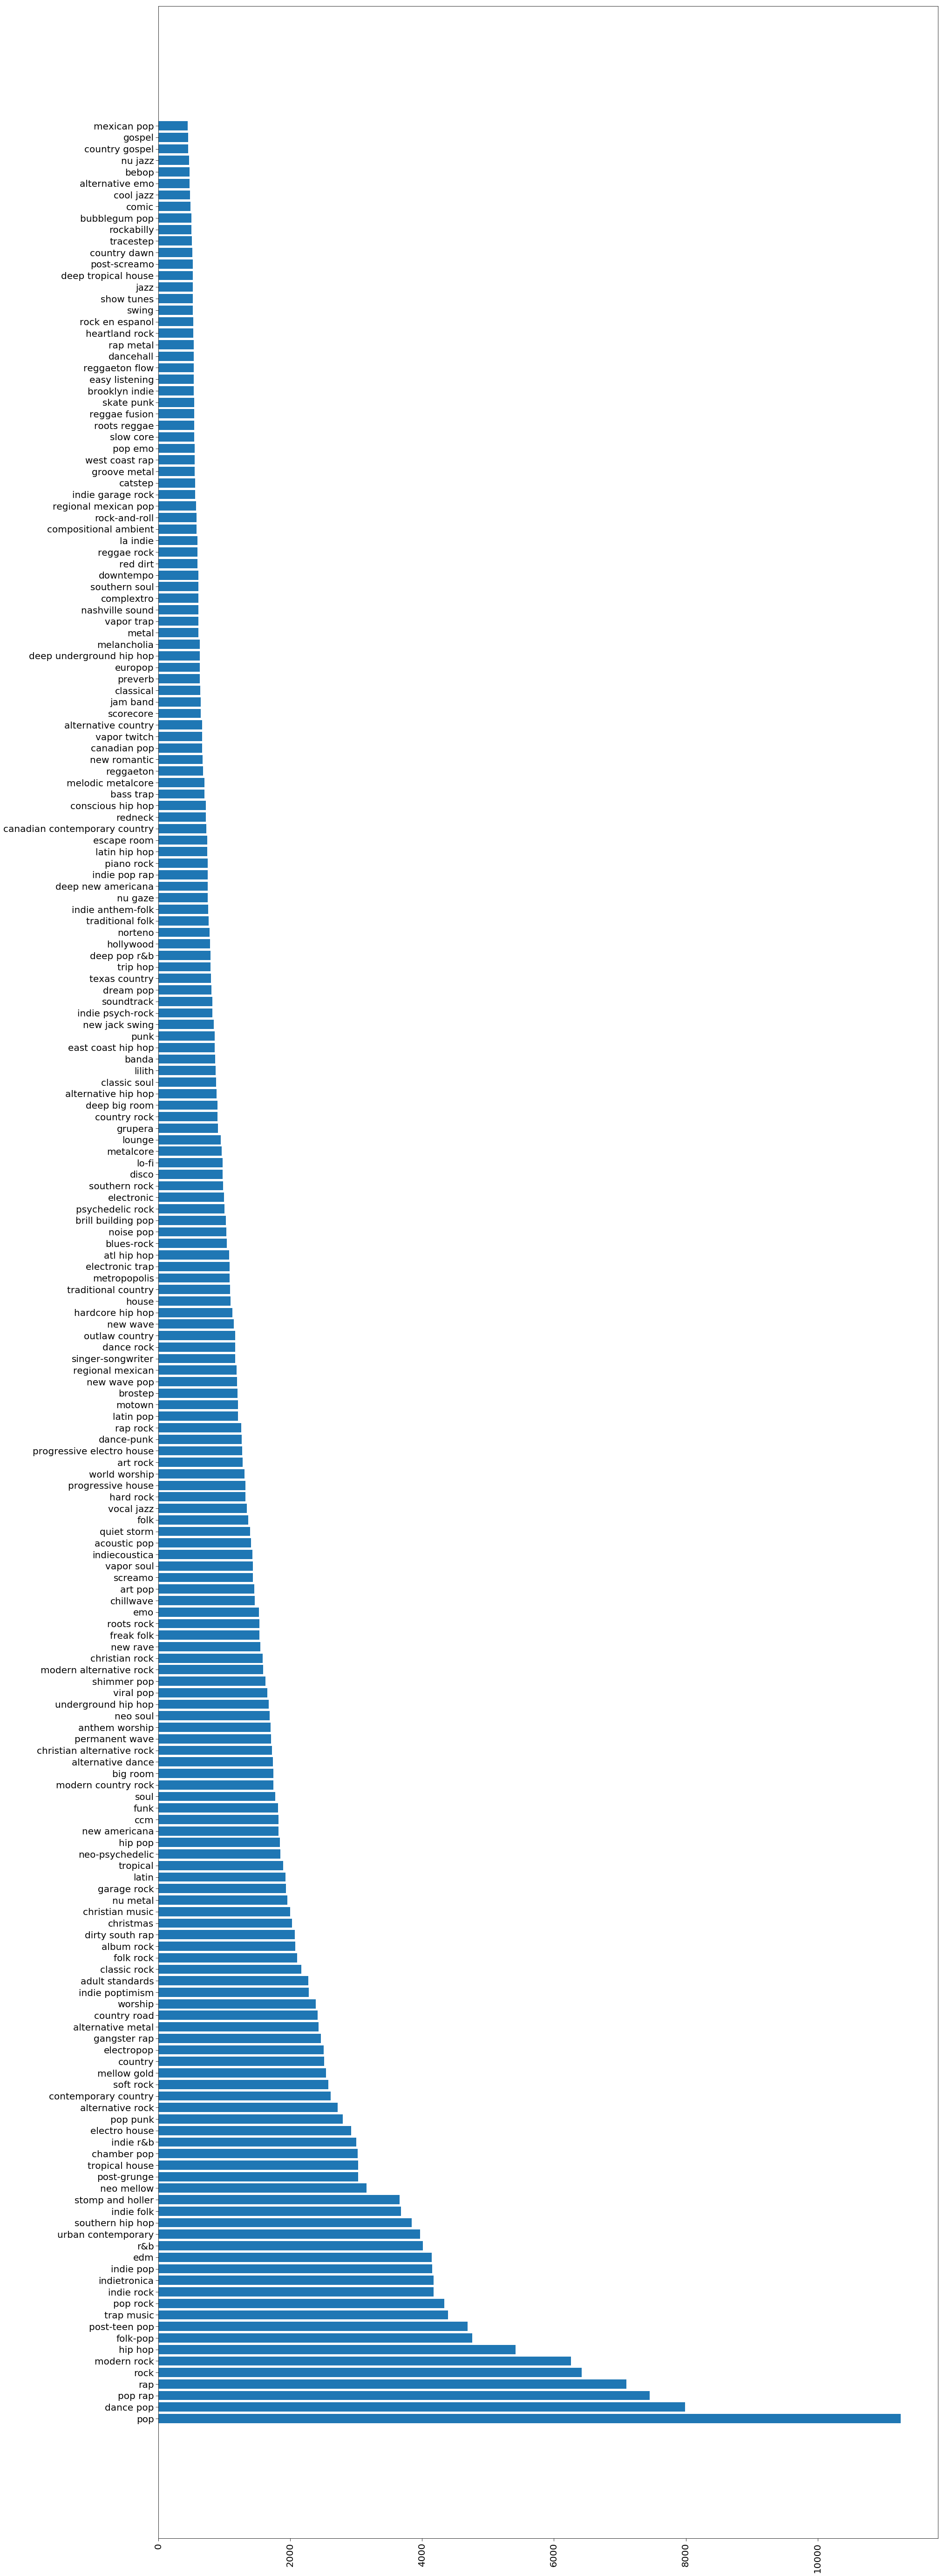

In [27]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 

fig, ax=plt.subplots(1, 1, figsize=(30,100))
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)


Observations are in EDA write-up

## Split train and test data

In [28]:
train_data, test_data = train_test_split(clean_data, test_size=0.2, random_state=42)

In [29]:
train_data.shape, test_data.shape

((757, 27), (190, 27))

In [30]:
train_data.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,liveness,loudness,mode,speechiness,time_signature,tempo,valence,year,popularity,genre
117,false,NaN,188188.023368,1476489600,Fall 2015,13,13,7,1,13,...,0.176085,0.752142,0.543054,0.041480,3.0,83.444866,0.455006,2015,15,texas country
84,false,NaN,81246.100899,1500940800,Workout2,35,26,17,1,39,...,0.096565,6.156249,0.221551,0.079439,1.0,36.921474,0.159599,2003,59,rap
577,false,NaN,119912.798508,1492387200,sound,26,21,6,1,31,...,0.113968,4.046746,0.428485,0.049871,2.0,55.970820,0.245326,1970,45,soft rock
888,false,NaN,70086.235269,1442880000,Old Rock,20,17,10,1,22,...,0.071140,5.904413,0.126268,0.018786,1.0,40.408561,0.120631,1989,59.5,soft rock
89,false,NaN,73425.028637,1489276800,80's,85,82,2,1,92,...,0.065163,4.896232,0.257439,0.035085,1.0,38.887906,0.171246,1985,61.5,soft rock


In [31]:
def make_row(track_id, row):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
            features[feature] = abs(features[feature] - row[feature])
    popularity = abs(popularity_data[track_id] - row['popularity'])
    features["popularity"] = int(popularity)
    return features

In [ ]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1
    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index >  len(songs) *2/3:
            track_id = track
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
#     other_keys = get_new_songs(row["genre"], row["year"])
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)

train_data_songs = train_data_songs.set_index("id")

'|###########################--| (684/757) with 0 failures'

In [ ]:
train_data_songs.head()

In [ ]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

In [ ]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [ ]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

In [ ]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

In [ ]:
# we don't plot tempo b/c it's off the charts
pltcols=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
         "valence", "popularity"]
xs = np.arange((len(pltcols))) - 0.25
inplaylist = []
notinplaylist = []
for col in pltcols:
    if col != "tempo":
        d = train_data_songs[col]
        inplaylist.append(np.mean(d[np.array(train_data_y) == 1]))
        notinplaylist.append(np.mean(d[np.array(train_data_y) == 0]))
    
print(inplaylist)
print(notinplaylist)

    
plt.bar(xs, inplaylist, align='center', width=0.5, label="in playlist")
plt.bar(xs + 0.5, notinplaylist, align='center', width=0.5, label="not in playlist")
plt.xlabel("predictor")
plt.ylabel("mean difference from playlist mean")
plt.xticks([r for r in range(len(pltcols))], pltcols, rotation=90)
plt.legend()

In [ ]:
train_data_x = train_data_songs[columns]
train_data_x.head()

In [ ]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index > len(songs) *2/3:
            track_id = track
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
#     other_keys = get_new_songs(row["genre"], row["year"])
    songs = []
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
            
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
test_data_x.head()

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=100)
logreg.fit(train_data_x, train_data_y)

In [ ]:
coefs = zip(train_data_x.columns, logreg.coef_[0])

In [ ]:
print(logreg.score(train_data_x, train_data_y))
print(logreg.score(test_data_x, test_data_y))

Can we improve it with cross-validation?

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [ ]:
# logregcv = LogisticRegressionCV(solver='saga', cv=5, max_iter=1000).fit(train_data_x, train_data_y)

In [ ]:
# logregcv.score(test_data_x, test_data_y)

What about a Neural Network?

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras import regularizers
from sklearn.metrics import r2_score as r2


In [ ]:
input_dim = len(columns)
n_hidden = 100

model = Sequential()
model.add(Dense(n_hidden, activation='relu', input_shape=(input_dim,)))
model.add(Dense(n_hidden, activation='sigmoid'))
model.add(Dense(n_hidden, activation='relu'))
model.add(Dense(n_hidden, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy',  metrics=['binary_accuracy'])
model.summary()

In [ ]:
epochs = 100
batch_size = 128

original_model = model.fit(train_data_x, train_data_y, epochs=epochs, validation_split = 0.5, verbose=0)

In [ ]:
print(model.metrics_names)
train_score = model.evaluate(train_data_x, train_data_y, verbose=1)
print('Train loss:', train_score)
print('Train R2:', r2(train_data_y, model.predict(train_data_x)))

test_score = model.evaluate(test_data_x, test_data_y, verbose=1)
print('Test loss:', test_score)
print('Test R2:', r2(test_data_y, model.predict(test_data_x)))

# Let's Try It!
We'll give our model a country playlist and ask it to select songs

In [ ]:
def getPlaylistSongs(id):
    url = base_url + '/playlists/' + id
    r =requests.get(url, headers=headers)
    data = r.json()
    return data['tracks']['items']

In [ ]:
def getSongs(songs):
    url = base_url + '/tracks'
    i = 0
    payload = {'ids': ','.join(songs)}
    r =requests.get(url, headers=headers, params=payload)
    data = r.json()
    names = []
    for track in data['tracks']:
        names.append(track['name'])
    return names

In [ ]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

def predictSongs(playlist_id, test_model):
    tracks = getPlaylistSongs(myplaylist)
    if tracks:
        features = {
            "acousticness": 0,
            "danceability": 0,
            "duration_ms" : 0,
            "energy" : 0,
            "instrumentalness" : 0,
            "key" : 0,
            "liveness" : 0,
            "loudness" : 0,
            "mode" : 0,
            "speechiness" : 0,
            "time_signature" : 0,
            "tempo" : 0,
            "valence" : 0,
        }
        albums = set({})
        years = set({})
        ids = set({})
        new_songs = pd.DataFrame([], columns=columns)
        songs = []
        seen = []
        for song in tracks:
            song_id = (song['track']['id'])
            ids.add(song_id)
            if song_id in feature_data:
                seen.append(song_id)
            else:
                songs.append(song_id)
                artist_id = song['track']['album']['artists'][0]['id']
                album_id = song['track']['album']['id']
                albums.add(album_id)
                artists.add(artist_id)
        try:
            song_features = get_features(songs)
            genres, genre_list = get_genres(list(artists))
            years, years_list = get_years(list(albums))
            popularity = get_popularity(songs)
            popularity_list = list(popularity)
            for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
                feature_data[song] = feature
                genre_data[song] = genre
                year_data[song] = year
                popularity_data[song] = pop
            # add data from our seen songs
            for song in seen:
                song_features.append(feature_data[song])
                if type(genre_data[song]) == list:
                    for genre in genre_data[song]:
                        genres[genre] += 1
                else:
                    genres[genre_data[song]] += 1
                popularity.append(popularity_data[song])
                years[year_data[song]] += 1

                # update popularity to be median value (not mean b/c outliers)
            popularity = np.median(popularity)
            features['popularity'] = popularity        

            # insert all information into features dict
            for song in song_features:
                for feature in all_features:
                    features[feature] += song[feature]
            # average necessary values and update data table
            for feature in feature_names:
                if feature in all_features:
                    features[feature] = features[feature] / len(tracks)
                    if feature == "time_signature":
                        features[feature] = int(features[feature] + 0.5)
                elif feature == "year":
                    features["year"] = int(years.most_common(1)[0][0])
                elif feature == "genre":
                    features["genre"] = genres.most_common(1)[0][0]

            random_songs = random.sample(song_keys, 30)
#             random_songs = get_new_songs(features["genre"], features["year"])
            sample_songs = pd.DataFrame([], columns=columns)
            for key in random_songs:
                if not key in ids and key in feature_data:
                    stats = make_row(key, features)
                    sample_songs = sample_songs.append(stats, ignore_index=True)
            predictions = test_model.predict(sample_songs[columns])
            predicted_songs = []
            print(predictions)
            for i in range(len(predictions)):
                if predictions[i] >= 0.5:
                    predicted_songs.append(sample_songs.loc[i, "id"])
            if(len(predicted_songs) > 50):
                predicted_songs = predicted_songs[:50]
            elif(len(predicted_songs) == 0):
                return('No songs could be found')
            song_names = getSongs(predicted_songs)
            return song_names
        except Exception as ex:
            print('error', ex)
    else:
        print("Playlist cannot be found. Make sure it's not private!")

In [ ]:
myplaylist = '4IRSXGb7jV2U8j06ToX1yz'
myplaylistfeatures = predictSongs(myplaylist, logreg)
print(myplaylistfeatures)

In [ ]:
myplaylist = '4IRSXGb7jV2U8j06ToX1yz'
myplaylistfeatures = predictSongs(myplaylist, model)
print(myplaylistfeatures)